# 8. How to average over a sphere

In [1]:
# Display the plots in the notebook:
%matplotlib inline

In [2]:
# Import the tools we are going to need today:
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size
np.set_printoptions(threshold=20)  # avoid to print very large arrays on screen
# The commands below are to ignore certain warnings.
import warnings
warnings.filterwarnings('ignore')

As our planet earth is a sphere (more or less), if we average over latitude and longitude we will always take the average over a sphere! You will have to pay attention with that, and here comes why: 
When averaging `[lon, lat]` data, one gives too much weight to high latitudes.
We can see that, when comparing a regular 2D plot to a spheric one. 

We do this for the 2 meter temperature:

In [3]:
ds = xr.open_dataset('./data/ERA5-LowRes-MonthlyAvg-t2m_tp.nc')
ds

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 480)
Coordinates:
  * longitude  (longitude) float32 -179.625 -178.875 ... 178.875 179.625
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Data variables:
    tp         (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-26 14:52:06 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [4]:
t2m_avg = ds.t2m.mean(dim='time')
t2m_avg.mean() -273.15 # this is way too cold!

<xarray.DataArray 't2m' ()>
array(5.200372)

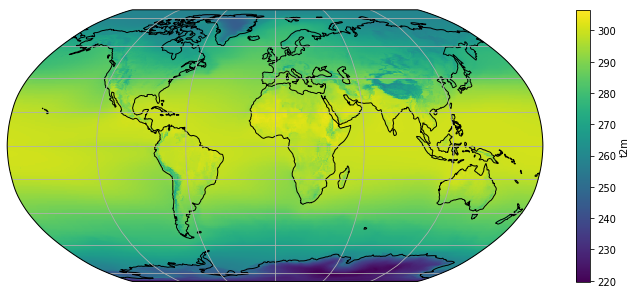

In [5]:
ax = plt.axes(projection=ccrs.Robinson())
t2m_avg.plot(ax=ax, transform=ccrs.PlateCarree()) 
ax.coastlines(); ax.gridlines(); 

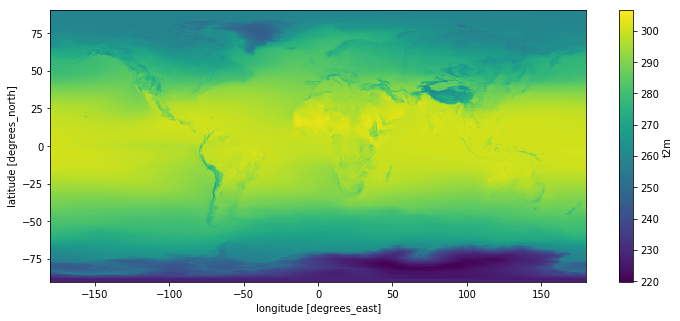

In [6]:
t2m_avg.plot();

If we compare those two plots, we recognise that in a grid space as we have it in our dataset (PlateCarre, second plot), high latitudes are given too much weight in comparison to the spheric plot! 

Fortunately, this can be solved by noting that we have to weight each latitudinal band by the cosinus of the latitude, i.e. $\cos \varphi$. This results in low latitudes having a lot of weight ($\cos ({0}) = 1$) and vice versa. We are going to compute a new average, but [weighted](https://en.wikipedia.org/wiki/Weighted_arithmetic_mean) this time. First, let's make a weight array:

In [7]:
weight = np.cos(np.deg2rad(ds.latitude)) #deg2rad converts the latitude from degrees to radians
weight = weight / weight.sum() #weigh each latitudinal band by dividing it by the summed weights

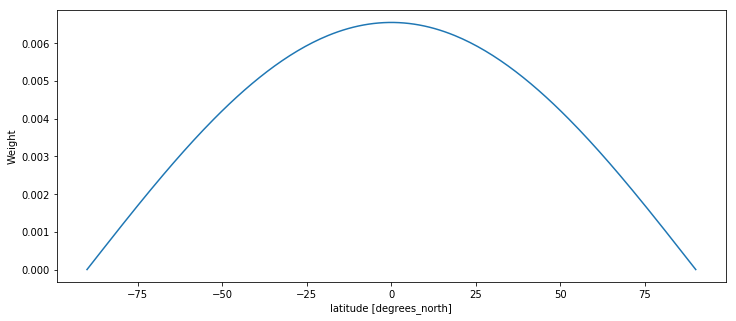

In [8]:
weight.plot();
plt.ylabel('Weight');

Weight is an array of 180 elements, which is normalised so that it's sum is 1. This is exactly what we need to compute a weighted average! First, we have to average over the longitudes (this is fine, because along a latitude circle all points have the same weight), and then compute the weighted average.

In [9]:
zonal_t2m_avg = t2m_avg.mean(dim='longitude')  # important! Always average over longitudes first
#this averaging is needed so that the arithmetic below makes sense (multiply two arrays of 180 elements with each other)
weighted_t2m_avg = np.sum(zonal_t2m_avg * weight) #sum over all weighted latitudinal t2m values
weighted_t2m_avg - 273.15 #physically resonable 2 meter temperature average

<xarray.DataArray ()>
array(14.247461)

The new result for the average 2 meter temperature on our globe is 14°C. This seems much more reasonable than the 5°C we had before doing those calculations.

To sum it up once more: whenever you **average over latitudes**, you will need to **take into account that our planet is a sphere** and do the arithmetics above in order to get the correct result!